In [1]:
import pandas as pd; pd.set_option('display.max_columns', None)
import numpy as np
import random
import matplotlib.pyplot as plt
from pycaret.classification import *
from sklearn.model_selection import train_test_split

import sys
sys.path.append('../../../scripts/')
from PreparaDatasetV2 import *

# Parâmetros do método

In [2]:
TARGET = 'Back_Home'
ODDS = 'Odds_H'

# Carregando o dataset

In [3]:
data = pd.read_csv('../../../data/Entire_Season.csv')
data = prepara_df(data)

In [4]:
def prepara_dataset(_df):

    _df = _df[(_df['Odds_H'] >= 1.6) & (_df['Odds_H'] <= 2.4)]

    _df.replace([np.inf, -np.inf], 0, inplace=True)
    _df.reset_index(drop=True, inplace=True)
    
    return _df

In [5]:
df = data.copy()
df = prepara_dataset(df)

In [6]:
treinamento, val = train_test_split(df, train_size=0.66, random_state=2023)
real_treino, real_teste = train_test_split(treinamento, train_size=0.5, random_state=2023)

print(f'Treino: {real_treino.shape[0]} | Teste: {real_teste.shape[0]} | Validação: {val.shape[0]}')

Treino: 762 | Teste: 763 | Validação: 786


# Criação do modelo

In [17]:
features = ['Over_Line', 'HA_Line',
       'HA_Odds_H', 'HA_Odds_A', 'P(H)', 'P(A)', 'P(O)', 'P(U)', 'P_Diff', 
       'Avg_CG_H', 'DP_CG_H', 'CV_CG_H', 'Avg_Pontos_H',
       'DP_Pontos_H', 'CV_Pontos_H', 'CG_H_Last_Game', 'Media_Odds_Geral_H',
       'DP_Odds_Geral_H', 'CV_Odds_Geral_H', 'Saldo_Gols_H', 'Avg_CG_A',
       'DP_CG_A', 'CV_CG_A', 'Avg_Pontos_A', 'DP_Pontos_A', 'CV_Pontos_A',
       'CG_A_Last_Game', 'Media_Odds_Geral_A', 'DP_Odds_Geral_A',
       'CV_Odds_Geral_A', 'Saldo_Gols_A', 'Goals_Last_H', 'Goals_Last_A',
       'Last_Odd_H', 'Last_Odd_A', 'MediaCustoGolHome', 'MediaCustoGolAway',
       'CV_ML', 'CV_Over', 'CV_HA', 'Retornos_BH_Acu', 'Avg_Retornos_BH',
       'Custo_Retorno_BH', 'Avg_Porc_BH_Bookie', 'Avg_Porc_BH_Real',
       'Dist_Porc_BH', 'Retornos_BA_Acu', 'Avg_Retornos_BA',
       'Custo_Retorno_BA', 'Avg_Porc_BA_Bookie', 'Avg_Porc_BA_Real',
       'Dist_Porc_BA']

features = ['Over_Line', 'HA_Line', 'HA_Odds_H', 'HA_Odds_A', 'P(H)', 'P(A)', 'P(O)', 'P(U)', 'P_Diff', 
       'CG_H_Last_Game', 'CG_A_Last_Game', 'Goals_Last_H', 'Goals_Last_A',
       'Last_Odd_H', 'Last_Odd_A', 'CV_ML', 'CV_Over', 'CV_HA']

In [86]:
# Ranges da variável
ranges_dict['Goals_Last_H']

[Interval(78.999, 102.2, closed='right'),
 Interval(102.2, 110.0, closed='right'),
 Interval(120.8, 143.0, closed='right')]

In [87]:
def filtra_resultados(_df, filtro = 0):

    if filtro == 1:
        _df = _df[((_df['CG_A_Last_Game'] < 0.0) | (_df['CG_A_Last_Game'] >= 160))]
        _df = _df[((_df['CV_HA'] < 0.0334) | (_df['CV_HA'] >= 1.414))]
        _df = _df[((_df['P_Diff'] < 0.0464) | (_df['P_Diff'] >= 0.065))]
        _df = _df[((_df['CG_A_Last_Game'] < 348) | (_df['CG_A_Last_Game'] >= 920))]
        _df = _df[((_df['Goals_Last_H'] >= 79) & (_df['Goals_Last_H'] <= 110)) | ((_df['Goals_Last_H'] > 120.8) & (_df['Goals_Last_H'] <= 143))]

    if filtro == 20:
        _df = _df[((_df['CG_A_Last_Game'] < 0.0) | (_df['CG_A_Last_Game'] >= 160))]
        _df = _df[((_df['Goals_Last_H'] < 114) | (_df['Goals_Last_H'] >= 121))]

    return _df

In [11]:
def calcula_profit(_df, stake = 1):
    _df.loc[(_df[TARGET] == 1), 'PL_BF_Predictions'] = (_df[ODDS] - 1) * stake
    _df.loc[(_df[TARGET] == 0), 'PL_BF_Predictions'] = - stake

    return _df

def exibe_metricas(_df, total, stake = 1, return_metrics = False):
    plb = _df['PL_BF_Predictions'].sum()
    entradas = _df.shape[0]
    wr = round((_df[_df[TARGET] == 1].shape[0] / entradas), 2)
    oddback = (_df[ODDS].mean())
    med_gain = _df[_df[TARGET] == 1]['PL_BF_Predictions'].mean()
    med_loss = _df[_df[TARGET] == 0]['PL_BF_Predictions'].mean()
    roi = plb / entradas
    porc_ent = entradas / total
    ev = (wr*stake*med_gain) + ((1-wr)*med_loss*stake)

    if return_metrics == False:
        print(f'PL: {plb:.2f} | ROI: {100*roi:.2f}% | Prec.: {wr:.2f}')
        print(f'Odd média: {oddback:.2f} ({1/oddback:.2f} WR)')
        print(f'Média Gain: {med_gain:.2f} | Média Loss: {med_loss:.2f}')
        print(f'EM: {ev:.2f}')
        print(f'{entradas} entradas em {total} jogos ({100*porc_ent:.2f}%)')
    else:
        return_metrics == True
        metrics = [plb, wr, oddback, med_gain, med_loss, roi, porc_ent, ev]
        return metrics

def exibe_grafico(_df, per_day = False):
    _df.sort_index(inplace=True)
    _df.reset_index(drop=True, inplace=True)
    
    if per_day:
        
        _df['Date'] = pd.to_datetime(_df['Date'])
        _df_per_day = _df.groupby(_df['Date'].dt.date)['PL_BF_Predictions'].sum()
        _df_per_day = _df_per_day.reset_index()
        
        # Criar um novo DataFrame com colunas 'Date' e 'Accumulated'
        new_df = pd.DataFrame({
            'Date': _df_per_day['Date'],
            'PL': _df_per_day['PL_BF_Predictions']
        })

        new_df['hbacu'] = new_df['PL'].cumsum()
        new_df['hbacu'].plot.line(figsize=(7, 2))
        plt.xlabel('Index')
        plt.ylabel('Acumulado')
        plt.title('Acumulado por dia')
        plt.show()

    else:
        _df['hbacu'] = _df['PL_BF_Predictions'].cumsum()
        _df['hbacu'].plot.line(figsize=(7, 2))
        plt.xlabel('Index')
        plt.ylabel('Acumulado')
        plt.title('Acumulado por jogo')
        plt.show()

def info_modelo(data, stake = 1, filtro = 0, per_day = False):
    total = data.shape[0]

    _df = filtra_resultados(data, filtro=filtro)
    _df = calcula_profit(_df, stake)
    exibe_metricas(_df, total, stake)
    exibe_grafico(_df, per_day)
    
    return _df


PL: 14.21 | ROI: 7.81% | Prec.: 0.57
Odd média: 1.95 (0.51 WR)
Média Gain: 0.90 | Média Loss: -1.00
EM: 0.09
182 entradas em 762 jogos (23.88%)


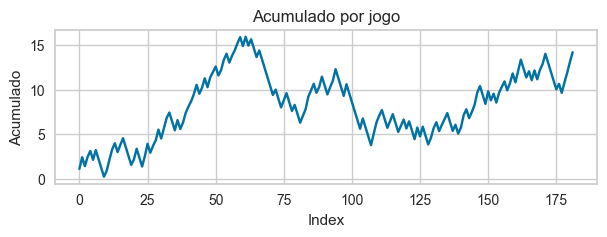

PL: 28.53 | ROI: 21.29% | Prec.: 0.63
Odd média: 1.93 (0.52 WR)
Média Gain: 0.91 | Média Loss: -1.00
EM: 0.20
134 entradas em 763 jogos (17.56%)


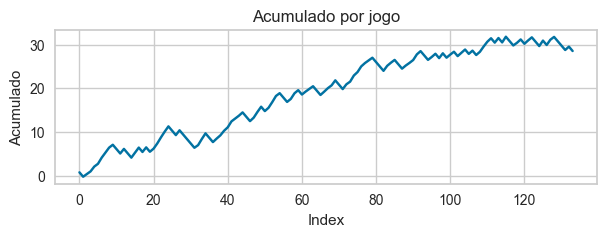

PL: 42.74 | ROI: 13.53% | Prec.: 0.59
Odd média: 1.94 (0.52 WR)
Média Gain: 0.91 | Média Loss: -1.00
EM: 0.13
316 entradas em 1525 jogos (20.72%)


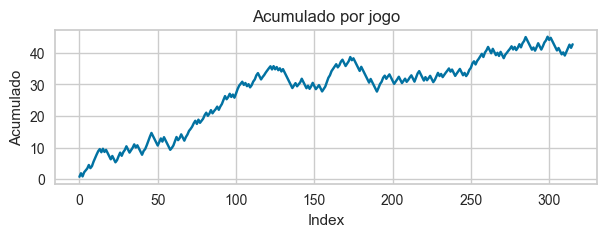

In [93]:
flt = 1

df_treino = info_modelo(real_treino, filtro = flt)
df_teste = info_modelo(real_teste, filtro = flt)
df_treinamento = info_modelo(treinamento, filtro = flt)

PL: 10.43 | ROI: 6.06% | Prec.: 0.57
Odd média: 1.90 (0.53 WR)
Média Gain: 0.86 | Média Loss: -1.00
EM: 0.06
172 entradas em 786 jogos (21.88%)


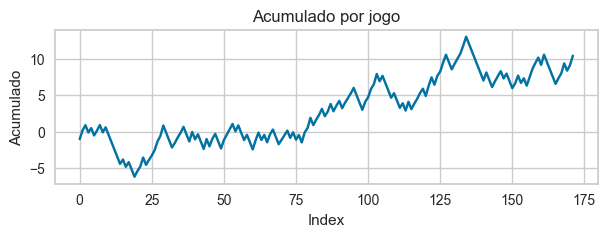

In [94]:
df_val = info_modelo(val, filtro = flt)

PL: 53.17 | ROI: 10.90% | Prec.: 0.59
Odd média: 1.93 (0.52 WR)
Média Gain: 0.89 | Média Loss: -1.00
EM: 0.12
488 entradas em 2311 jogos (21.12%)


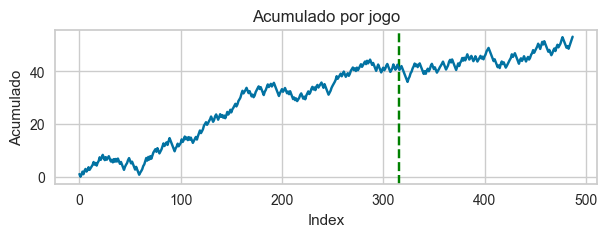

In [97]:
plt.axvline(x=len(pd.concat([df_treino, df_teste])), color='green', linestyle='--')
comp = pd.concat([df_treino, df_teste, df_val])
exibe_metricas(comp, total=len(treinamento) + len(val))
exibe_grafico(comp)

# QCut automático

In [14]:
def find_pos_range(var, treino, teste, validacao, ratio = 0.03, return_train = True, return_val = False):
    nome = f'Cat_{var}'

    # Usa qcut para definir os grupos
    teste[nome]  = pd.qcut(teste[var], q = 5, duplicates='drop')

    target = 'PL_BF_Predictions'
    pivot_table = pd.pivot_table(teste,
                                values=target,
                                index=[nome],
                                aggfunc=['sum', 'count']
                                )

    pivot_table['ratio'] = pivot_table[('sum', target)] / pivot_table[('count', target)]

    ranges = pivot_table[pivot_table['ratio'] > ratio].index.tolist()

    # Máscara booleana para filtrar o DataFrame
    mascara_treino = treino[var].apply(lambda x: any(x in range for range in ranges))
    mascara_teste = teste[var].apply(lambda x: any(x in range for range in ranges))
    mascara_val = validacao[var].apply(lambda x: any(x in range for range in ranges))
        
    # Aplicar a máscara para obter o DataFrame filtrado
    teste_filtrado = teste[mascara_teste]
    treino_filtrado = treino[mascara_treino]
    val_filtrado = validacao[mascara_val]

    print(f'{var}\n')
    if return_train == True:
        print('---------------------  TREINO  ---------------------')
        exibe_metricas(treino_filtrado, total=len(real_treino))
        exibe_grafico(treino_filtrado)
    print('---------------------  TESTE  ---------------------')
    exibe_metricas(teste_filtrado, total=len(real_teste))
    exibe_grafico(teste_filtrado)
    if return_val == True:
        print('---------------------  VALIDAÇÃO  ---------------------')
        exibe_metricas(val_filtrado, total=len(val))
        exibe_grafico(val_filtrado)
    print('\n\n')

    return ranges


def find_top_range(var, treino, teste, validacao, ratio = 3, return_train = True, return_val = False):
    nome = f'Cat_{var}'

    # Usa qcut para definir os grupos
    teste[nome]  = pd.qcut(teste[var], q = 5, duplicates='drop')

    target = 'PL_BF_Predictions'
    pivot_table = pd.pivot_table(teste,
                                values=target,
                                index=[nome],
                                aggfunc=['sum', 'count']
                                )
    

    pivot_table['ratio'] = pivot_table[('sum', target)] / pivot_table[('count', target)]

    pivot_table.sort_values('ratio', ascending=True, inplace=True)
    ranges = pivot_table.index.tolist()

    ranges = ranges[:ratio]

    # Máscara booleana para filtrar o DataFrame
    mascara_treino = treino[var].apply(lambda x: any(x in range for range in ranges))
    mascara_teste = teste[var].apply(lambda x: any(x in range for range in ranges))
    mascara_val = validacao[var].apply(lambda x: any(x in range for range in ranges))
    
    # Aplicar a máscara para obter o DataFrame filtrado
    teste_filtrado = teste[mascara_teste]
    treino_filtrado = treino[mascara_treino]
    val_filtrado = validacao[mascara_val]

    print(f'{var}\n')
    if return_train == True:
        print('---------------------  TREINO  ---------------------')
        exibe_metricas(treino_filtrado, total=len(real_treino))
        exibe_grafico(treino_filtrado)
    print('---------------------  TESTE  ---------------------')
    exibe_metricas(teste_filtrado, total=len(real_teste))
    exibe_grafico(teste_filtrado)
    if return_val == True:
        print('---------------------  VALIDAÇÃO  ---------------------')
        exibe_metricas(val_filtrado, total=len(val))
        exibe_grafico(val_filtrado)
    print('\n\n')

    return ranges


def find_neg_range(var, treino, teste, validacao, return_train = True, return_val = False):
    nome = f'Cat_{var}'

    # Usa qcut para definir os grupos
    teste[nome]  = pd.qcut(teste[var], q = 5, duplicates='drop')

    target = 'PL_BF_Predictions'
    pivot_table = pd.pivot_table(teste,
                                values=target,
                                index=[nome],
                                aggfunc=['sum', 'count']
                                )
    

    pivot_table['ratio'] = pivot_table[('sum', target)] / pivot_table[('count', target)]

    pivot_table.sort_values('ratio', ascending=True, inplace=True)
    ranges = pivot_table.index.tolist()
    
    # Pegar apenas o primeiro intervalo da lista
    range = ranges[0]

    # Criar a máscara booleana para valores dentro do primeiro intervalo
    mascara_treino = treino[var].apply(lambda x: x in range)
    mascara_teste = teste[var].apply(lambda x: x in range)
    mascara_val = validacao[var].apply(lambda x: x in range)

    mascara_treino = ~mascara_treino
    mascara_teste = ~mascara_teste
    mascara_val = ~mascara_val
    
    # Aplicar a máscara para obter o DataFrame filtrado
    treino_filtrado = treino[mascara_treino]
    teste_filtrado = teste[mascara_teste]
    val_filtrado = validacao[mascara_val]

    print(f'{var}\n')
    if return_train == True:
        print('---------------------  TREINO  ---------------------')
        exibe_metricas(treino_filtrado, total=len(real_treino))
        exibe_grafico(treino_filtrado)
    print('---------------------  TESTE  ---------------------')
    exibe_metricas(teste_filtrado, total=len(real_teste))
    exibe_grafico(teste_filtrado)
    if return_val == True:
        print('---------------------  VALIDAÇÃO  ---------------------')
        exibe_metricas(val_filtrado, total=len(val))
        exibe_grafico(val_filtrado)
    print('\n\n')

    return range

In [75]:
autocut_treino = df_treino.copy()
autocut_teste = df_teste.copy()
autocut_val = df_val.copy()

Over_Line

---------------------  TREINO  ---------------------
PL: 3.79 | ROI: 2.61% | Prec.: 0.53
Odd média: 1.96 (0.51 WR)
Média Gain: 0.93 | Média Loss: -1.00
EM: 0.02
145 entradas em 762 jogos (19.03%)


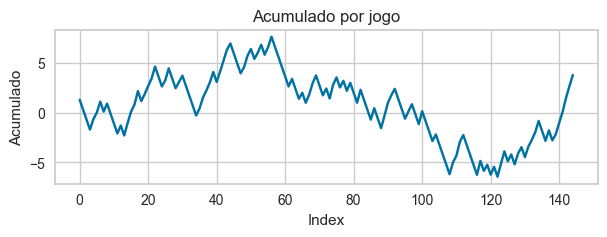

---------------------  TESTE  ---------------------
PL: 21.18 | ROI: 16.55% | Prec.: 0.62
Odd média: 1.90 (0.53 WR)
Média Gain: 0.89 | Média Loss: -1.00
EM: 0.17
128 entradas em 763 jogos (16.78%)


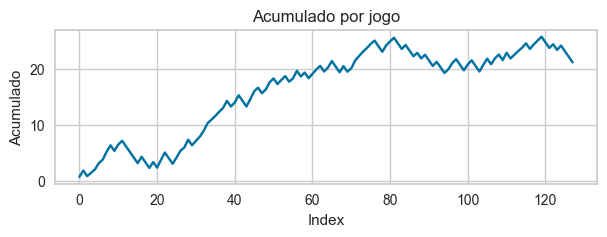

---------------------  VALIDAÇÃO  ---------------------
PL: 6.84 | ROI: 4.38% | Prec.: 0.57
Odd média: 1.88 (0.53 WR)
Média Gain: 0.83 | Média Loss: -1.00
EM: 0.04
156 entradas em 786 jogos (19.85%)


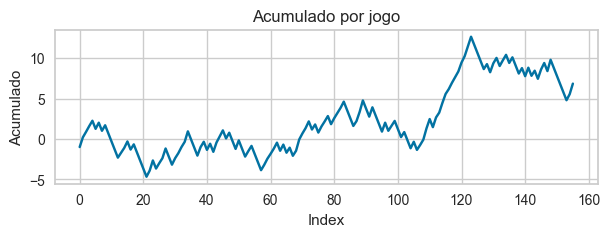




HA_Line

---------------------  TREINO  ---------------------
PL: 14.53 | ROI: 11.53% | Prec.: 0.56
Odd média: 2.05 (0.49 WR)
Média Gain: 1.01 | Média Loss: -1.00
EM: 0.12
126 entradas em 762 jogos (16.54%)


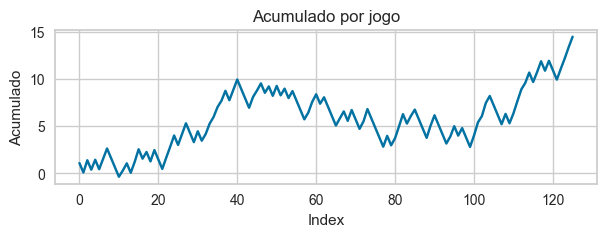

---------------------  TESTE  ---------------------
PL: 20.90 | ROI: 19.72% | Prec.: 0.60
Odd média: 2.02 (0.50 WR)
Média Gain: 0.98 | Média Loss: -1.00
EM: 0.19
106 entradas em 763 jogos (13.89%)


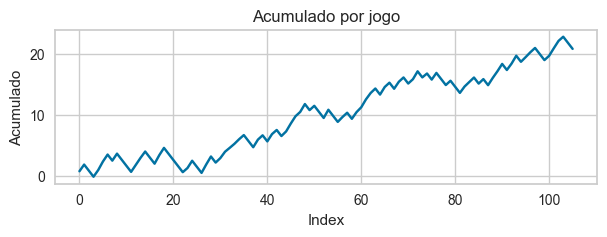

---------------------  VALIDAÇÃO  ---------------------
PL: -2.48 | ROI: -2.21% | Prec.: 0.50
Odd média: 1.99 (0.50 WR)
Média Gain: 0.96 | Média Loss: -1.00
EM: -0.02
112 entradas em 786 jogos (14.25%)


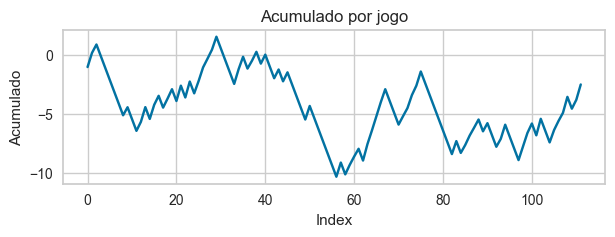




HA_Odds_H

---------------------  TREINO  ---------------------
PL: 7.54 | ROI: 3.12% | Prec.: 0.54
Odd média: 1.94 (0.52 WR)
Média Gain: 0.90 | Média Loss: -1.00
EM: 0.03
242 entradas em 762 jogos (31.76%)


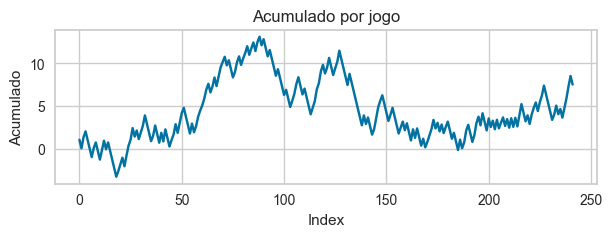

---------------------  TESTE  ---------------------
PL: 18.97 | ROI: 9.30% | Prec.: 0.58
Odd média: 1.92 (0.52 WR)
Média Gain: 0.89 | Média Loss: -1.00
EM: 0.10
204 entradas em 763 jogos (26.74%)


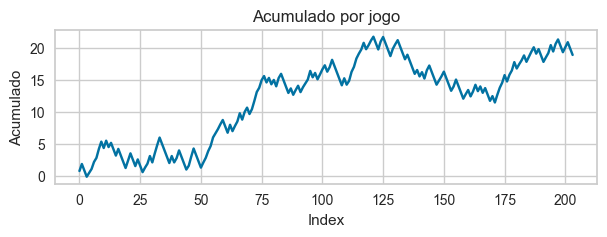

---------------------  VALIDAÇÃO  ---------------------
PL: 0.29 | ROI: 0.12% | Prec.: 0.54
Odd média: 1.88 (0.53 WR)
Média Gain: 0.84 | Média Loss: -1.00
EM: -0.01
239 entradas em 786 jogos (30.41%)


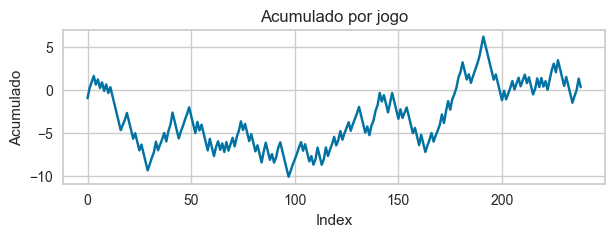




HA_Odds_A

---------------------  TREINO  ---------------------
PL: 7.77 | ROI: 12.33% | Prec.: 0.57
Odd média: 1.95 (0.51 WR)
Média Gain: 0.97 | Média Loss: -1.00
EM: 0.12
63 entradas em 762 jogos (8.27%)


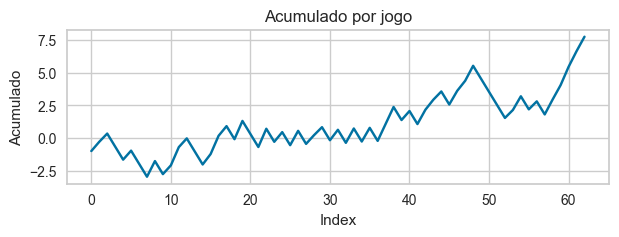

---------------------  TESTE  ---------------------
PL: 7.10 | ROI: 16.51% | Prec.: 0.63
Odd média: 1.92 (0.52 WR)
Média Gain: 0.86 | Média Loss: -1.00
EM: 0.17
43 entradas em 763 jogos (5.64%)


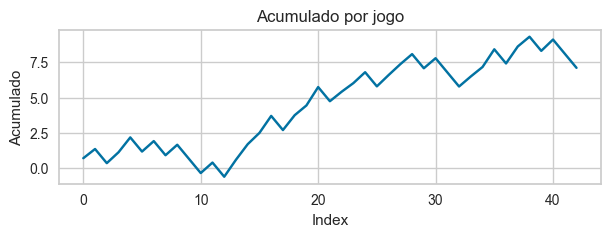

---------------------  VALIDAÇÃO  ---------------------
PL: 2.11 | ROI: 3.40% | Prec.: 0.55
Odd média: 1.94 (0.52 WR)
Média Gain: 0.89 | Média Loss: -1.00
EM: 0.04
62 entradas em 786 jogos (7.89%)


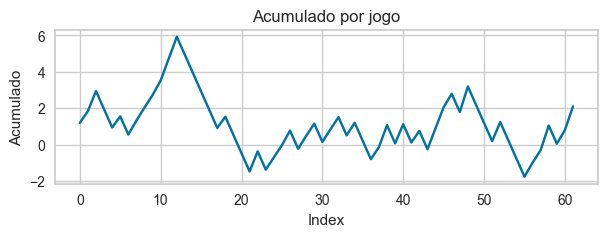




P(H)

---------------------  TREINO  ---------------------
PL: -3.03 | ROI: -3.06% | Prec.: 0.48
Odd média: 2.06 (0.49 WR)
Média Gain: 1.00 | Média Loss: -1.00
EM: -0.04
99 entradas em 762 jogos (12.99%)


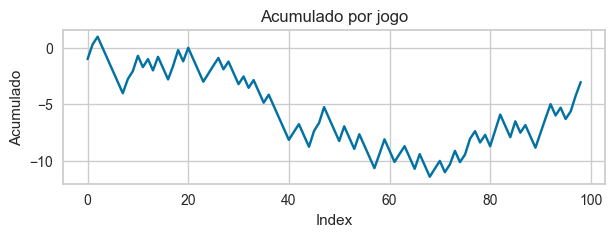

---------------------  TESTE  ---------------------
PL: 11.77 | ROI: 13.85% | Prec.: 0.56
Odd média: 2.07 (0.48 WR)
Média Gain: 1.02 | Média Loss: -1.00
EM: 0.13
85 entradas em 763 jogos (11.14%)


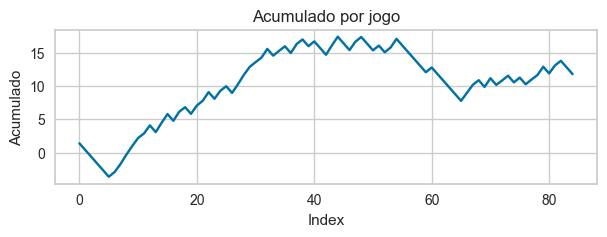

---------------------  VALIDAÇÃO  ---------------------
PL: 4.52 | ROI: 5.38% | Prec.: 0.54
Odd média: 2.04 (0.49 WR)
Média Gain: 0.97 | Média Loss: -1.00
EM: 0.06
84 entradas em 786 jogos (10.69%)


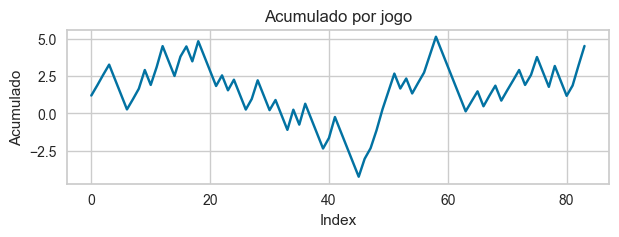




P(A)

---------------------  TREINO  ---------------------
PL: 10.27 | ROI: 8.63% | Prec.: 0.53
Odd média: 2.09 (0.48 WR)
Média Gain: 1.05 | Média Loss: -1.00
EM: 0.09
119 entradas em 762 jogos (15.62%)


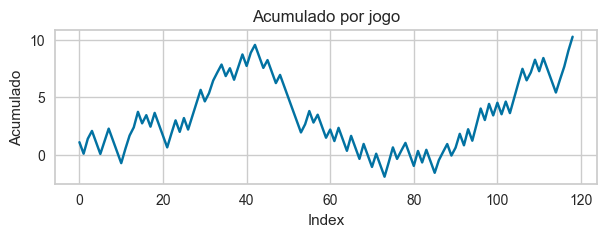

---------------------  TESTE  ---------------------
PL: 12.93 | ROI: 13.76% | Prec.: 0.56
Odd média: 2.06 (0.49 WR)
Média Gain: 1.02 | Média Loss: -1.00
EM: 0.13
94 entradas em 763 jogos (12.32%)


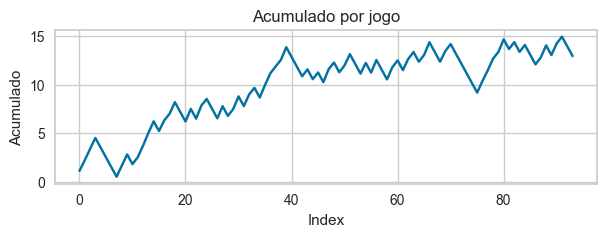

---------------------  VALIDAÇÃO  ---------------------
PL: 8.45 | ROI: 8.99% | Prec.: 0.54
Odd média: 2.06 (0.49 WR)
Média Gain: 1.01 | Média Loss: -1.00
EM: 0.08
94 entradas em 786 jogos (11.96%)


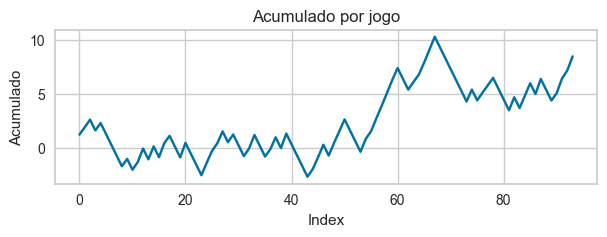




P(O)

---------------------  TREINO  ---------------------
PL: 7.94 | ROI: 11.68% | Prec.: 0.57
Odd média: 1.93 (0.52 WR)
Média Gain: 0.95 | Média Loss: -1.00
EM: 0.11
68 entradas em 762 jogos (8.92%)


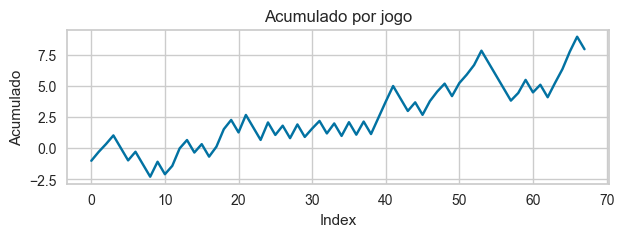

---------------------  TESTE  ---------------------
PL: 4.17 | ROI: 8.18% | Prec.: 0.59
Odd média: 1.90 (0.53 WR)
Média Gain: 0.84 | Média Loss: -1.00
EM: 0.09
51 entradas em 763 jogos (6.68%)


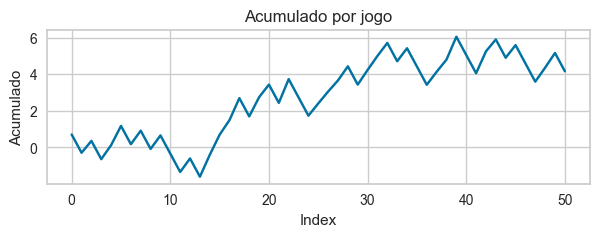

---------------------  VALIDAÇÃO  ---------------------
PL: 1.38 | ROI: 2.09% | Prec.: 0.55
Odd média: 1.93 (0.52 WR)
Média Gain: 0.87 | Média Loss: -1.00
EM: 0.03
66 entradas em 786 jogos (8.40%)


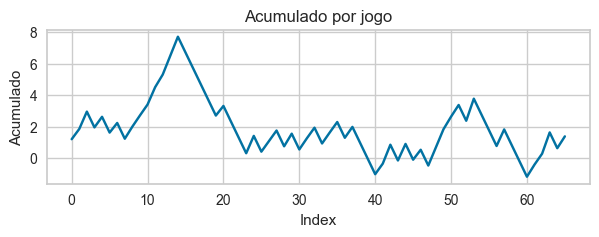




P(U)

---------------------  TREINO  ---------------------
PL: 9.35 | ROI: 13.17% | Prec.: 0.58
Odd média: 1.93 (0.52 WR)
Média Gain: 0.96 | Média Loss: -1.00
EM: 0.14
71 entradas em 762 jogos (9.32%)


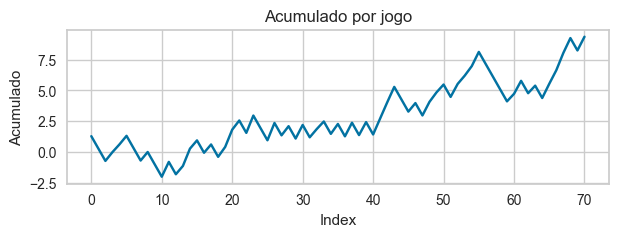

---------------------  TESTE  ---------------------
PL: 3.67 | ROI: 6.44% | Prec.: 0.58
Odd média: 1.90 (0.53 WR)
Média Gain: 0.84 | Média Loss: -1.00
EM: 0.07
57 entradas em 763 jogos (7.47%)


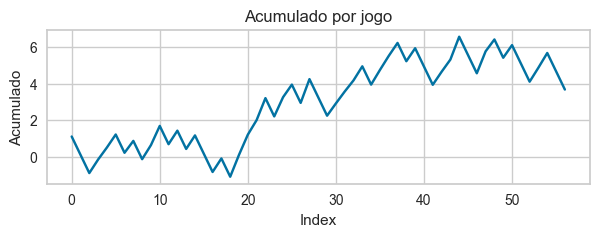

---------------------  VALIDAÇÃO  ---------------------
PL: 2.94 | ROI: 4.20% | Prec.: 0.56
Odd média: 1.92 (0.52 WR)
Média Gain: 0.87 | Média Loss: -1.00
EM: 0.05
70 entradas em 786 jogos (8.91%)


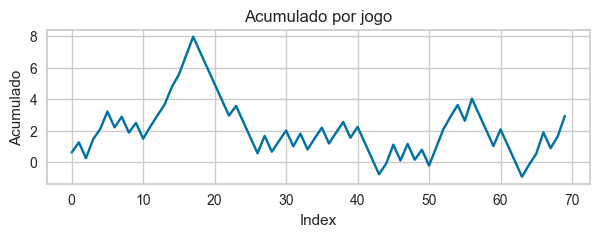




P_Diff

---------------------  TREINO  ---------------------
PL: 3.13 | ROI: 4.89% | Prec.: 0.55
Odd média: 2.00 (0.50 WR)
Média Gain: 0.92 | Média Loss: -1.00
EM: 0.05
64 entradas em 762 jogos (8.40%)


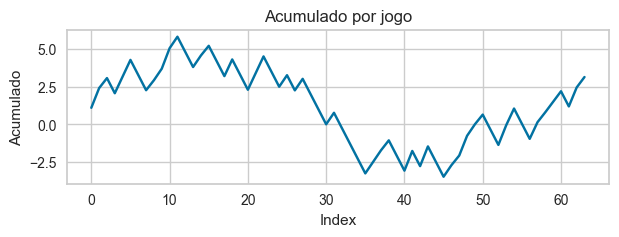

---------------------  TESTE  ---------------------
PL: 14.85 | ROI: 27.50% | Prec.: 0.67
Odd média: 1.91 (0.52 WR)
Média Gain: 0.91 | Média Loss: -1.00
EM: 0.28
54 entradas em 763 jogos (7.08%)


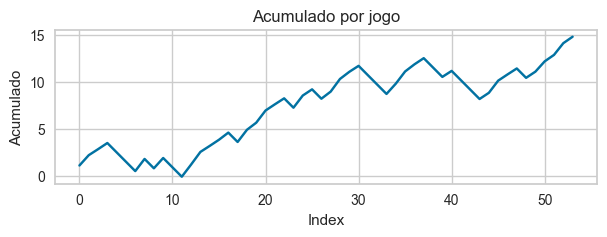

---------------------  VALIDAÇÃO  ---------------------
PL: 0.14 | ROI: 0.19% | Prec.: 0.56
Odd média: 1.85 (0.54 WR)
Média Gain: 0.80 | Média Loss: -1.00
EM: 0.01
72 entradas em 786 jogos (9.16%)


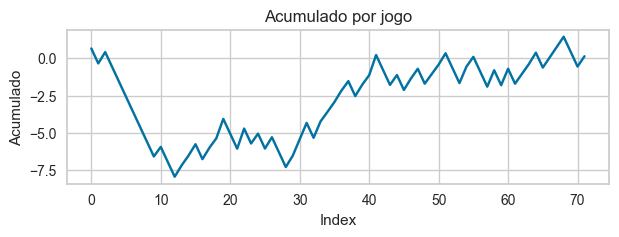




CG_H_Last_Game

---------------------  TREINO  ---------------------
PL: 17.53 | ROI: 9.18% | Prec.: 0.58
Odd média: 1.93 (0.52 WR)
Média Gain: 0.90 | Média Loss: -1.00
EM: 0.10
191 entradas em 762 jogos (25.07%)


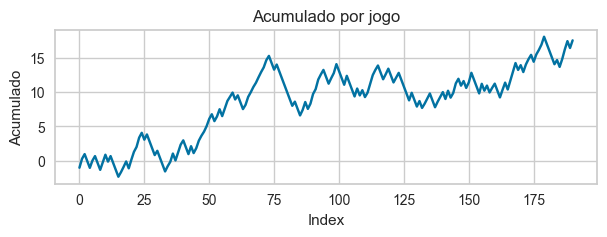

---------------------  TESTE  ---------------------
PL: 14.47 | ROI: 8.51% | Prec.: 0.58
Odd média: 1.91 (0.52 WR)
Média Gain: 0.88 | Média Loss: -1.00
EM: 0.09
170 entradas em 763 jogos (22.28%)


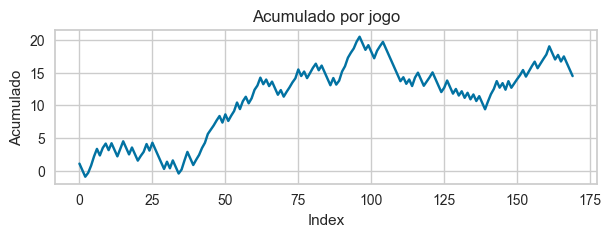

---------------------  VALIDAÇÃO  ---------------------
PL: 0.18 | ROI: 0.09% | Prec.: 0.54
Odd média: 1.88 (0.53 WR)
Média Gain: 0.85 | Média Loss: -1.00
EM: 0.00
198 entradas em 786 jogos (25.19%)


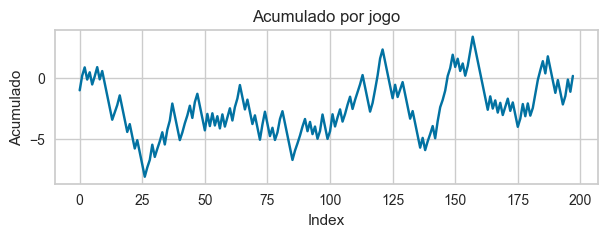




CG_A_Last_Game

---------------------  TREINO  ---------------------
PL: 4.28 | ROI: 4.41% | Prec.: 0.54
Odd média: 1.97 (0.51 WR)
Média Gain: 0.95 | Média Loss: -1.00
EM: 0.05
97 entradas em 762 jogos (12.73%)


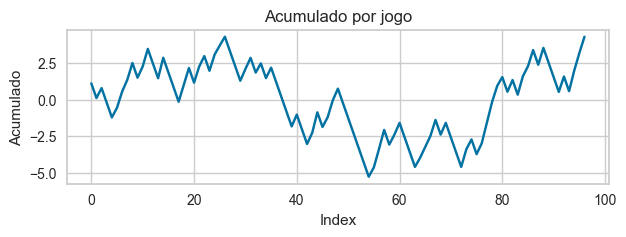

---------------------  TESTE  ---------------------
PL: 18.97 | ROI: 22.06% | Prec.: 0.65
Odd média: 1.92 (0.52 WR)
Média Gain: 0.87 | Média Loss: -1.00
EM: 0.22
86 entradas em 763 jogos (11.27%)


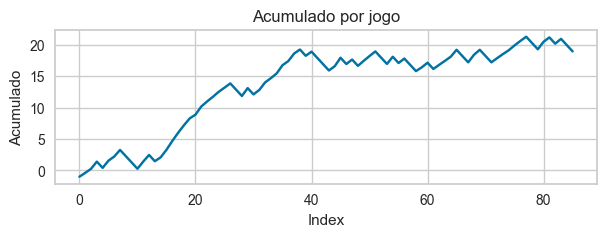

---------------------  VALIDAÇÃO  ---------------------
PL: 0.32 | ROI: 0.31% | Prec.: 0.55
Odd média: 1.85 (0.54 WR)
Média Gain: 0.83 | Média Loss: -1.00
EM: 0.00
102 entradas em 786 jogos (12.98%)


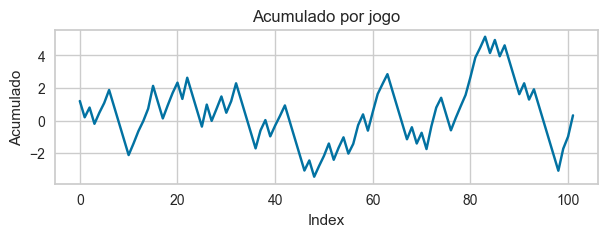




Goals_Last_H

---------------------  TREINO  ---------------------
PL: 14.21 | ROI: 7.81% | Prec.: 0.57
Odd média: 1.95 (0.51 WR)
Média Gain: 0.90 | Média Loss: -1.00
EM: 0.09
182 entradas em 762 jogos (23.88%)


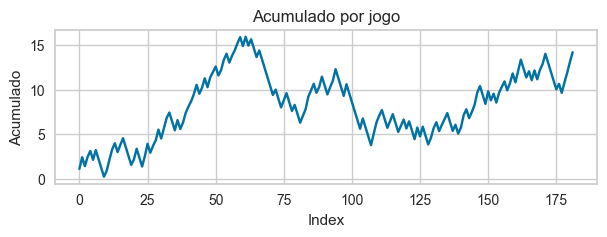

---------------------  TESTE  ---------------------
PL: 28.53 | ROI: 21.29% | Prec.: 0.63
Odd média: 1.93 (0.52 WR)
Média Gain: 0.91 | Média Loss: -1.00
EM: 0.20
134 entradas em 763 jogos (17.56%)


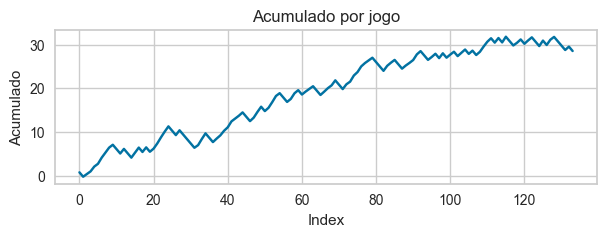

---------------------  VALIDAÇÃO  ---------------------
PL: 10.43 | ROI: 6.06% | Prec.: 0.57
Odd média: 1.90 (0.53 WR)
Média Gain: 0.86 | Média Loss: -1.00
EM: 0.06
172 entradas em 786 jogos (21.88%)


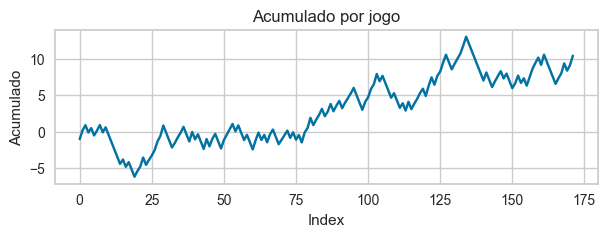




Goals_Last_A

---------------------  TREINO  ---------------------
PL: 5.15 | ROI: 3.84% | Prec.: 0.54
Odd média: 1.94 (0.52 WR)
Média Gain: 0.91 | Média Loss: -1.00
EM: 0.03
134 entradas em 762 jogos (17.59%)


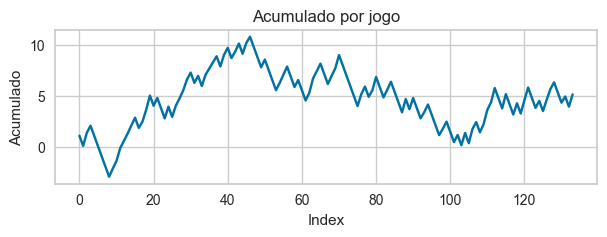

---------------------  TESTE  ---------------------
PL: 18.34 | ROI: 14.33% | Prec.: 0.59
Odd média: 1.96 (0.51 WR)
Média Gain: 0.93 | Média Loss: -1.00
EM: 0.14
128 entradas em 763 jogos (16.78%)


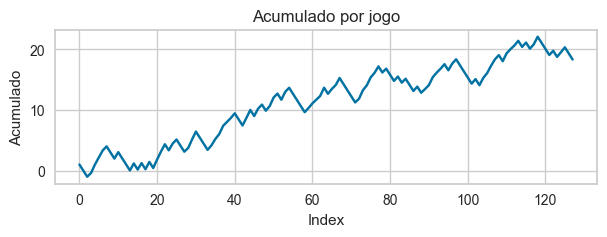

---------------------  VALIDAÇÃO  ---------------------
PL: -6.83 | ROI: -4.27% | Prec.: 0.52
Odd média: 1.88 (0.53 WR)
Média Gain: 0.85 | Média Loss: -1.00
EM: -0.04
160 entradas em 786 jogos (20.36%)


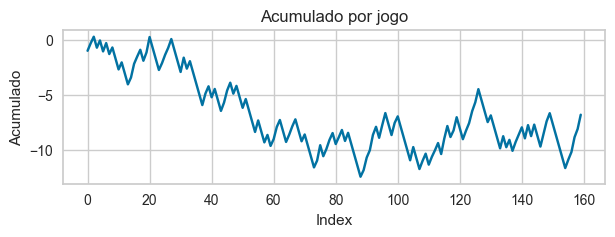




Last_Odd_H

---------------------  TREINO  ---------------------
PL: -14.25 | ROI: -9.69% | Prec.: 0.47
Odd média: 1.96 (0.51 WR)
Média Gain: 0.92 | Média Loss: -1.00
EM: -0.10
147 entradas em 762 jogos (19.29%)


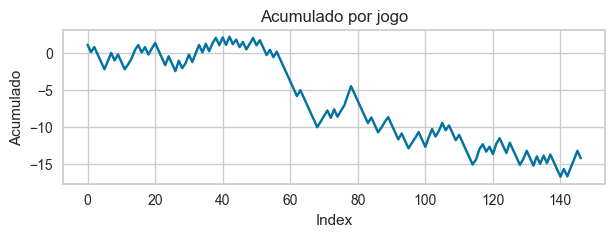

---------------------  TESTE  ---------------------
PL: 17.22 | ROI: 13.89% | Prec.: 0.59
Odd média: 1.94 (0.51 WR)
Média Gain: 0.93 | Média Loss: -1.00
EM: 0.14
124 entradas em 763 jogos (16.25%)


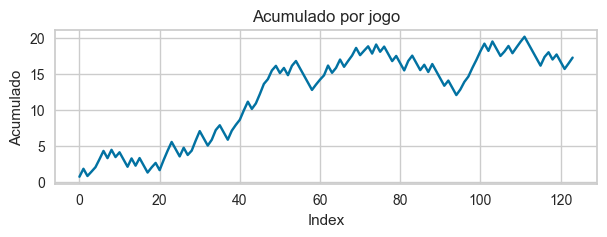

---------------------  VALIDAÇÃO  ---------------------
PL: -4.28 | ROI: -3.17% | Prec.: 0.53
Odd média: 1.91 (0.52 WR)
Média Gain: 0.84 | Média Loss: -1.00
EM: -0.02
135 entradas em 786 jogos (17.18%)


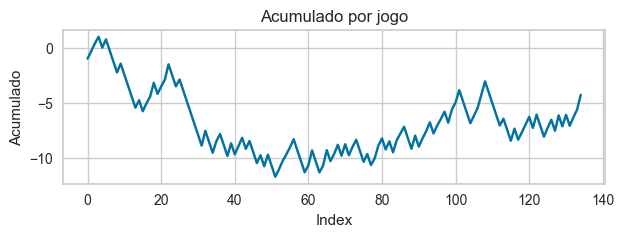




Last_Odd_A

---------------------  TREINO  ---------------------
PL: 7.53 | ROI: 5.16% | Prec.: 0.56
Odd média: 1.91 (0.52 WR)
Média Gain: 0.87 | Média Loss: -1.00
EM: 0.05
146 entradas em 762 jogos (19.16%)


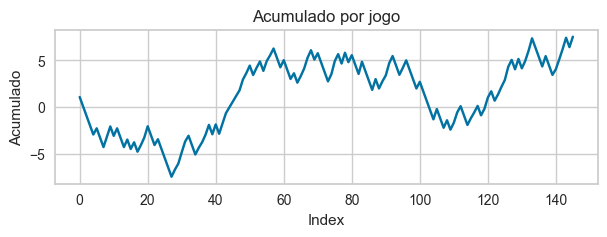

---------------------  TESTE  ---------------------
PL: 15.65 | ROI: 12.32% | Prec.: 0.60
Odd média: 1.89 (0.53 WR)
Média Gain: 0.88 | Média Loss: -1.00
EM: 0.13
127 entradas em 763 jogos (16.64%)


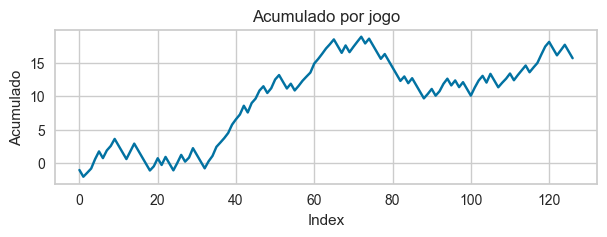

---------------------  VALIDAÇÃO  ---------------------
PL: 2.04 | ROI: 1.38% | Prec.: 0.55
Odd média: 1.87 (0.53 WR)
Média Gain: 0.83 | Média Loss: -1.00
EM: 0.01
148 entradas em 786 jogos (18.83%)


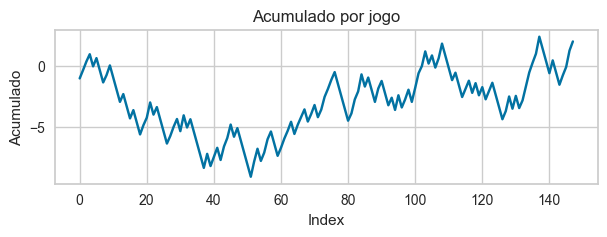




CV_ML

---------------------  TREINO  ---------------------
PL: -0.10 | ROI: -0.08% | Prec.: 0.52
Odd média: 1.96 (0.51 WR)
Média Gain: 0.91 | Média Loss: -1.00
EM: -0.01
126 entradas em 762 jogos (16.54%)


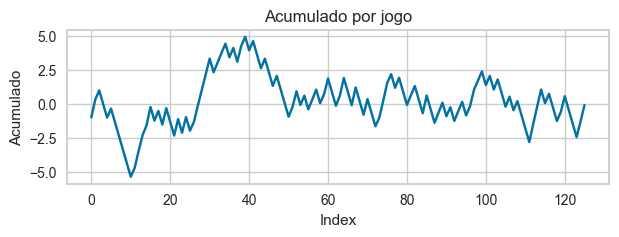

---------------------  TESTE  ---------------------
PL: 15.40 | ROI: 12.22% | Prec.: 0.60
Odd média: 1.92 (0.52 WR)
Média Gain: 0.89 | Média Loss: -1.00
EM: 0.13
126 entradas em 763 jogos (16.51%)


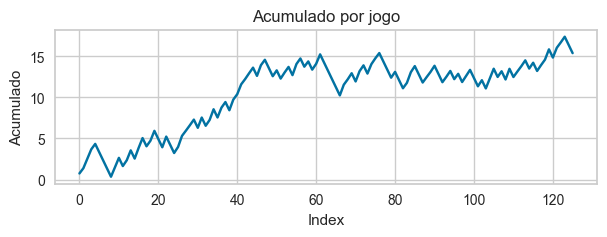

---------------------  VALIDAÇÃO  ---------------------
PL: 8.16 | ROI: 6.53% | Prec.: 0.58
Odd média: 1.89 (0.53 WR)
Média Gain: 0.85 | Média Loss: -1.00
EM: 0.07
125 entradas em 786 jogos (15.90%)


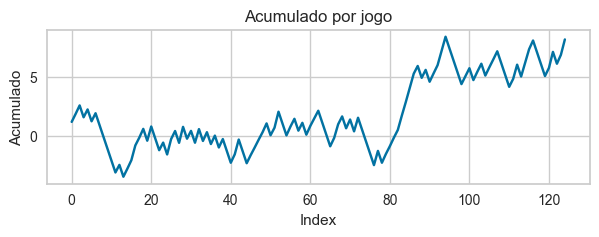




CV_Over

---------------------  TREINO  ---------------------
PL: 10.01 | ROI: 4.12% | Prec.: 0.55
Odd média: 1.94 (0.52 WR)
Média Gain: 0.90 | Média Loss: -1.00
EM: 0.05
243 entradas em 762 jogos (31.89%)


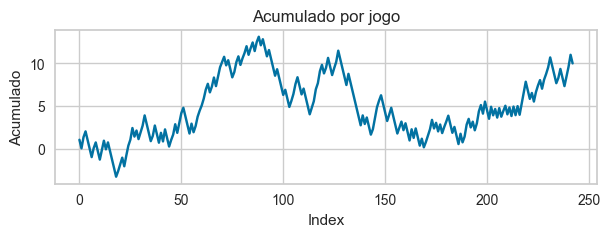

---------------------  TESTE  ---------------------
PL: 13.50 | ROI: 6.40% | Prec.: 0.56
Odd média: 1.92 (0.52 WR)
Média Gain: 0.89 | Média Loss: -1.00
EM: 0.06
211 entradas em 763 jogos (27.65%)


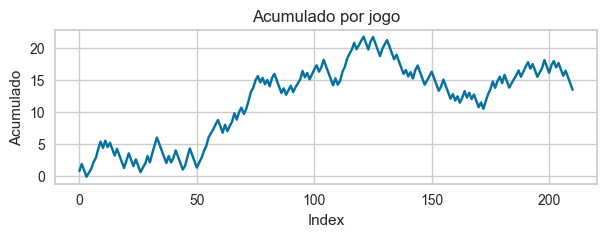

---------------------  VALIDAÇÃO  ---------------------
PL: 1.86 | ROI: 0.77% | Prec.: 0.55
Odd média: 1.88 (0.53 WR)
Média Gain: 0.84 | Média Loss: -1.00
EM: 0.01
243 entradas em 786 jogos (30.92%)


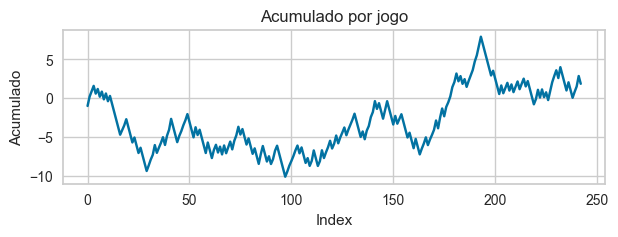




CV_HA

---------------------  TREINO  ---------------------
PL: 13.93 | ROI: 5.69% | Prec.: 0.56
Odd média: 1.94 (0.52 WR)
Média Gain: 0.90 | Média Loss: -1.00
EM: 0.07
245 entradas em 762 jogos (32.15%)


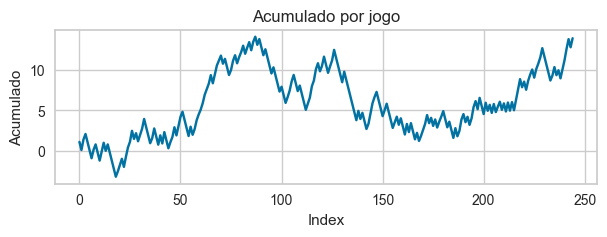

---------------------  TESTE  ---------------------
PL: 15.50 | ROI: 7.42% | Prec.: 0.57
Odd média: 1.92 (0.52 WR)
Média Gain: 0.89 | Média Loss: -1.00
EM: 0.08
209 entradas em 763 jogos (27.39%)


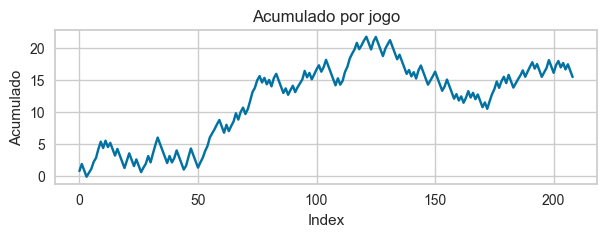

---------------------  VALIDAÇÃO  ---------------------
PL: 1.81 | ROI: 0.74% | Prec.: 0.55
Odd média: 1.88 (0.53 WR)
Média Gain: 0.84 | Média Loss: -1.00
EM: 0.01
245 entradas em 786 jogos (31.17%)


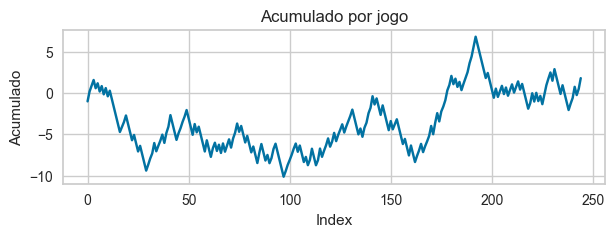

In [77]:
variaveis = features.copy()

ranges_dict = {}

for var in variaveis:
    try:
        new_range = find_pos_range(var, treino = autocut_treino, teste = autocut_teste, validacao = autocut_val, ratio = 0.05, return_train=True, return_val=True)
        # new_range = find_neg_range(var, treino = autocut_treino, teste = autocut_teste, validacao=autocut_val, return_train=True, return_val=True)
        # new_range = find_top_range(var, treino = autocut_treino, teste = autocut_teste, validacao = autocut_val, ratio = 3, return_train=True, return_val=True)
        ranges_dict[var] = new_range
    except:
        pass

# Script qcut

In [90]:
# df_cut1 = df_treino.copy()
df_cut = df_treinamento.copy()
# df_cut = pd.concat([df_cut1, df_cut2])

In [92]:
variaveis = features.copy()

for var in variaveis:
    try:
        nome = f'Cat_{var}'
        # Usa qcut para definir os grupos
        df_cut[nome]  = pd.qcut(df_cut[var], q = 5, duplicates='drop')

        target = 'PL_BF_Predictions'
        pivot_table = pd.pivot_table(df_cut,
                                    values=target,
                                    index=[nome],
                                    aggfunc=['sum', 'count']
                                    )
        

        pivot_table['ratio'] = pivot_table[('sum', target)] / pivot_table[('count', target)]

        aux_treino = pivot_table[pivot_table['ratio'] != 0]


        print(var)
        print(aux_treino)
        print()
        print('\n\n')
        print('------------------------------------------------')
        print('\n\n')
    except:
        pass

Over_Line
                              sum             count     ratio
                PL_BF_Predictions PL_BF_Predictions          
Cat_Over_Line                                                
(-0.001, 214.5]             22.42                69  0.324928
(214.5, 219.5]               4.78                64  0.074687
(219.5, 224.5]               8.87                60  0.147833
(224.5, 230.5]              -2.25                66 -0.034091
(230.5, 244.5]               8.92                57  0.156491




------------------------------------------------



HA_Line
                             sum             count     ratio
               PL_BF_Predictions PL_BF_Predictions          
Cat_HA_Line                                                 
(-8.501, -3.5]              6.41                95  0.067474
(-3.5, -2.5]               17.61                51  0.345294
(-2.5, 1.5]                18.90                98  0.192857
(1.5, 2.5]                  2.60                51  0.050980
(2.